<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/skorch_CIFAR10_cv_v003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR-10 CNN (v003) ###

*Given the significant demands on memory (and I am using a MacBook so no CUDA for me), have to run this in Google Colab for baller T4 CUDA...*

In [39]:
# !pip install skorch
# !pip install torchmetrics

In [2]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix
    , accuracy_score, ConfusionMatrixDisplay
    )
from torchmetrics import Accuracy, ConfusionMatrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from timeit import default_timer as timer
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda"  # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps"  # Use Apple Silicon GPU (if available)
else:
    device = "cpu"  # Default to CPU if no GPU is available

device

'cuda'

In [4]:
# ---------------------------------------------------------
# 1. Prepare dataset (CIFAR-10) with Augmentations
# ---------------------------------------------------------

# Train transforms (with augmentations)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# Test transforms (only normalize)
test_transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

# CIFAR-10 dataset download
dataset = datasets.CIFAR10(
    './data', train=True, download=True
)

# Extract raw data and labels
X = torch.tensor(dataset.data).permute(0, 3, 1, 2).float() / 255.0  # Convert to [N, C, H, W]
y = torch.tensor(dataset.targets)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test .shape

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


(torch.Size([40000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000]),
 torch.Size([10000]))

In [5]:
# ---------------------------------------------------------
# 2. Apply Transforms for Augmentation/Normalization
# ---------------------------------------------------------

# Define functions to apply transforms to batches (used in DataLoader)
train_transform_batch = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip images with 50% probability
    transforms.RandomCrop(32, padding=4),  # Add padding and crop randomly
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])

test_transform_batch = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # CIFAR-10 stats
])


# Wrap in DataLoader for batching
train_loader = DataLoader(
    list(zip(X_train, y_train))
    , batch_size=128
    , shuffle=True
)

test_loader = DataLoader(
    list(zip(X_test, y_test))
    , batch_size=128
    , shuffle=False
)

In [6]:
# # Split into training and testing sets
# X = torch.tensor(dataset.data).permute(0, 3, 1, 2).float() / 255.0

# # Normalize manually using CIFAR10 stats (aligning with transform above)
# mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
# std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
# X = (X - mean) / std
# y = torch.tensor(dataset.targets)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2
#     , random_state=27
#     , stratify=y
# )

X_train.shape, X_test.shape, y_train.shape, y_test .shape

(torch.Size([40000, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([40000]),
 torch.Size([10000]))

In [ ]:
# # Wrap in DataLoader for batching
# train_loader = DataLoader(
#     list(zip(X_train, y_train))
#     , batch_size=128
#     , shuffle=True)

# test_loader = DataLoader(
#     list(zip(X_test, y_test))
#     , batch_size=128
#     , shuffle=False)

In [7]:
class Cifar10CNN_v3(nn.Module):
    def __init__(self, channels=64, dropout=0.3):
        super().__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(3, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)

        # Convolutional block 2
        self.conv2 = nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels * 2)

        # Convolutional block 3
        self.conv3 = nn.Conv2d(channels * 2, channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(channels * 4)

        # Convolutional block 4
        self.conv4 = nn.Conv2d(channels * 4, channels * 8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(channels * 8)

        # Global average pooling to reduce overfitting
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(channels * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_out = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        # Global average pooling
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        return self.fc_out(x)

In [8]:
%%time
# 3. Wrap (a base model) with skorch

net = NeuralNetClassifier(
    module=Cifar10CNN_v3
    , criterion=nn.CrossEntropyLoss
    , max_epochs=10
    , lr=0.0001
    , optimizer=torch.optim.Adam
    , batch_size=128
    , iterator_train__shuffle=True
    , device=device
)

net.fit(X_train, y_train)

print("Train accuracy:", net.score(X_train, y_train))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5651       0.5199        1.2752  5.6074
      2        1.1371       0.5845        1.1694  4.2864
      3        0.9609       0.6539        0.9764  4.4175
      4        0.8508       0.6681        0.9181  4.5093
      5        0.7538       0.6619        1.0008  4.4015
      6        0.6754       0.7105        0.8519  4.3180
      7        0.6032       0.7334        0.7742  4.2865
      8        0.5361       0.6881        0.9893  5.2351
      9        0.4785       0.6551        1.1563  4.9584
     10        0.4285       0.6109        1.4342  5.5588
Train accuracy: 0.708975
CPU times: user 45.1 s, sys: 513 ms, total: 45.6 s
Wall time: 49.9 s


In [9]:
# 4a. RandomizedSearchCV for Hyperparams Tuning

# (param_dist_v3)

param_dist = {
    "module__channels": [32, 64, 128],  # Increasing upper range
    "module__dropout": [0.2, 0.3, 0.5],  # Slightly reduced dropout values
    "lr": [1e-4, 3e-4, 1e-3],  # Removed extreme values for better control
    "optimizer": [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    "batch_size": [64, 128],  # Added smaller batch size for exploration
    "optimizer__momentum": [0.0, 0.9],
    "optimizer__weight_decay": [0.0, 1e-4, 5e-4],
}

In [10]:
%%time

# 4b. Randomized Search Actual (sample combos, actual run;)

rs = RandomizedSearchCV(
    estimator=net
    , param_distributions=param_dist
    , n_iter=10
    , cv=3
    , scoring="accuracy"
    , verbose=1
    , random_state=27
    , n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best CV accuracy:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7322       0.3776        1.7492  4.4208
      2        1.3041       0.4898        1.4306  4.5251
      3        1.0954       0.6352        1.0212  4.4276
      4        0.9468       0.5594        1.2473  4.5499
      5        0.8336       0.6801        0.9099  4.5220
      6        0.7322       0.6697        0.9771  4.4291
      7        0.6414       0.6700        0.9879  4.5313
      8        0.5661       0.7469        0.7465  4.4131
      9        0.4894       0.6950        0.9143  4.4233
     10        0.4343       0.7475        0.7763  4.5257
Best CV accuracy: 0.7108251708842594
Best params: {'optimizer__weight_decay': 0.0, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 64, 'lr': 0.0003, 'batch_size': 128}
CPU times: 

In [11]:
# 5. Send results to a dataframe for clean review;

results = pd.DataFrame(rs.cv_results_)
results[[
    "mean_test_score"
    , "std_test_score"
    , "params"
]].sort_values("mean_test_score", ascending=False, inplace=True)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer__momentum,param_optimizer,param_module__dropout,param_module__channels,param_lr,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,131.307479,8.667714,2.116713,0.503485,0.0001,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.5,128,0.0001,128,"{'optimizer__weight_decay': 0.0001, 'optimizer...",0.686366,0.698942,0.497787,0.627699,0.092004,3
1,57.940185,6.460549,1.258338,0.192699,0.0000,0.0,<class 'torch.optim.rmsprop.RMSprop'>,0.2,64,0.0001,128,"{'optimizer__weight_decay': 0.0, 'optimizer__m...",0.672041,0.576464,0.510913,0.586473,0.066160,4
2,36.566407,2.107070,0.865899,0.173721,0.0005,0.9,<class 'torch.optim.sgd.SGD'>,0.5,32,0.0001,64,"{'optimizer__weight_decay': 0.0005, 'optimizer...",0.308085,0.317933,0.323033,0.316350,0.006204,6


In [12]:
results['params'].iloc[0]

{'optimizer__weight_decay': 0.0001,
 'optimizer__momentum': 0.0,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'module__dropout': 0.5,
 'module__channels': 128,
 'lr': 0.0001,
 'batch_size': 128}

In [ ]:
"""
Best params: {'optimizer__weight_decay': 0.0, 'optimizer__momentum': 0.9, 'optimizer': <class 'torch.optim.rmsprop.RMSprop'>, 'module__dropout': 0.3, 'module__channels': 64, 'lr': 0.0003, 'batch_size': 128}


{'optimizer__weight_decay': 0.0001,
 'optimizer__momentum': 0.0,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'module__dropout': 0.5,
 'module__channels': 128,
 'lr': 0.0001,
 'batch_size': 128}

"""

In [13]:
# 6. Predict & Evaluate Performance with Best Model

best_model = rs.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:\n", accuracy_score(y_test, y_pred))
print('\n=================================================================\n')
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\n=================================================================\n')
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = ConfusionMatrix(num_classes=10, task='multiclass')
cm_tensor = cm(torch.tensor(y_pred), y_test)

Accuracy:
 0.7557


Confusion Matrix:
 [[729   8  41  14  30   2   9  78  52  37]
 [  7 911   2   2   1   1   4   7  16  49]
 [ 44   3 585  27 114  41  53 123   8   2]
 [  7   5  41 394 113 161  76 162  21  20]
 [  4   0  16   8 765   7  21 171   6   2]
 [  2   2  22  82  43 646  31 159   7   6]
 [  2   2  18  20  49  15 862  25   5   2]
 [  4   0   9   6  16  16   5 940   3   1]
 [ 26  19   6   8   8   3   6  18 887  19]
 [ 18  70   1   4   3   1   4  47  14 838]]


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      1000
           1       0.89      0.91      0.90      1000
           2       0.79      0.58      0.67      1000
           3       0.70      0.39      0.50      1000
           4       0.67      0.77      0.71      1000
           5       0.72      0.65      0.68      1000
           6       0.80      0.86      0.83      1000
           7       0.54      0.94      0.69      1000
           8     

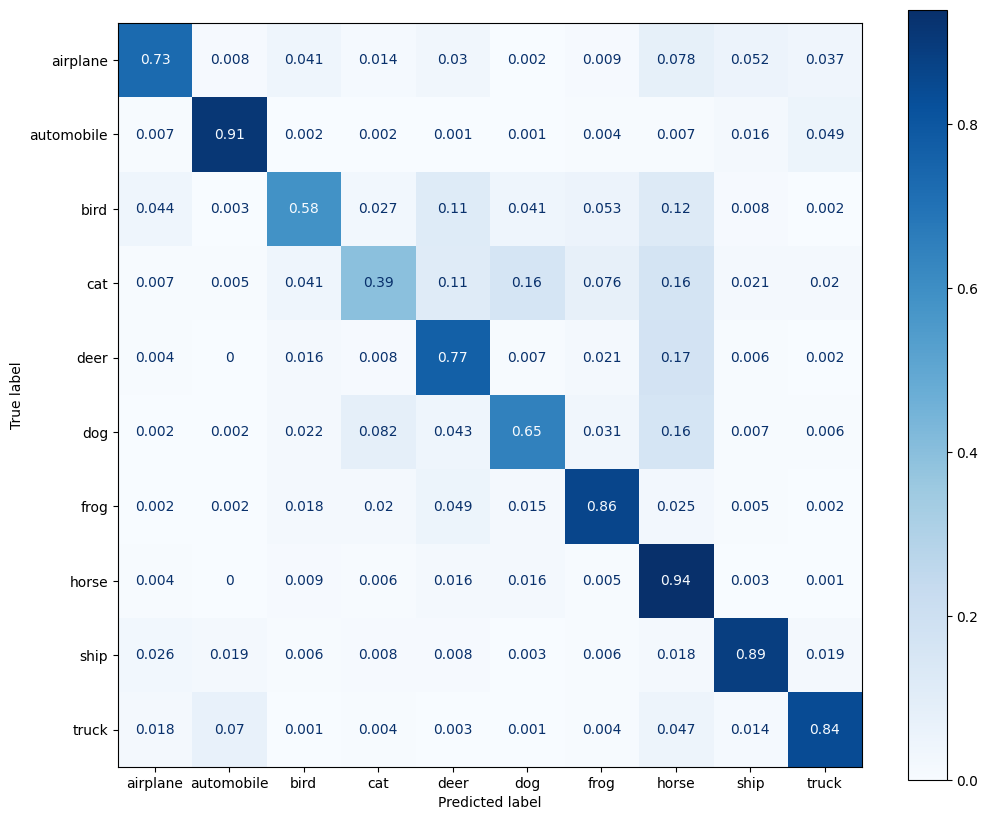

In [15]:
# 7. Plot the Confusion Matrix

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     y_test, y_pred
#     , display_labels=dataset.classes
#     , cmap='Blues'
#     , normalize='true', xticks_rotation=45
# )

disp.plot(ax=ax, cmap='Blues')
plt.show();

In [16]:
 # 8. Functionize the train & test loop(s):

def train_step(model, loader, loss_fn, optimizer, accuracy_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        # Apply train transforms to the batch
        X = train_transform_batch(X)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

def test_step(model, loader, loss_fn, accuracy_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            # Apply test transforms to the batch
            X = test_transform_batch(X)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()
    return total_loss / len(loader), total_acc / len(loader)

In [17]:
# ---------------------------------------------------------
# 9. Set the final model with the best params (including channels & dropout)
# ---------------------------------------------------------

model = Cifar10CNN_v3(
    channels=rs.best_params_["module__channels"]
    , dropout=rs.best_params_["module__dropout"]
).to(device)

model


# model = Cifar10CNN_v3(
#     num_filters=best_params['module__num_filters'],
#     num_units=best_params['module__num_units'],
#     dropout=best_params['module__dropout']
# ).to(device)

# model

Cifar10CNN_v3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [18]:
%%time

# 10. Train the Best Model

epochs = 50  # Increased to 50

optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)


for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step()  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  2%|▏         | 1/50 [00:05<04:51,  5.94s/it]

Epoch 1/50 - Train Loss: 1.4994, Train Acc: 0.44 - Test Loss: 1.4527, Test Acc: 0.50


  4%|▍         | 2/50 [00:11<04:35,  5.74s/it]

Epoch 2/50 - Train Loss: 1.1380, Train Acc: 0.59 - Test Loss: 1.1006, Test Acc: 0.60


  6%|▌         | 3/50 [00:17<04:30,  5.75s/it]

Epoch 3/50 - Train Loss: 0.9979, Train Acc: 0.65 - Test Loss: 1.0011, Test Acc: 0.65


  8%|▊         | 4/50 [00:22<04:22,  5.71s/it]

Epoch 4/50 - Train Loss: 0.9085, Train Acc: 0.68 - Test Loss: 1.0985, Test Acc: 0.64


 10%|█         | 5/50 [00:28<04:14,  5.66s/it]

Epoch 5/50 - Train Loss: 0.8495, Train Acc: 0.70 - Test Loss: 1.1342, Test Acc: 0.64


 12%|█▏        | 6/50 [00:34<04:12,  5.73s/it]

Epoch 6/50 - Train Loss: 0.7981, Train Acc: 0.72 - Test Loss: 0.8478, Test Acc: 0.70


 14%|█▍        | 7/50 [00:40<04:07,  5.75s/it]

Epoch 7/50 - Train Loss: 0.7544, Train Acc: 0.74 - Test Loss: 1.0121, Test Acc: 0.67


 16%|█▌        | 8/50 [00:45<03:59,  5.69s/it]

Epoch 8/50 - Train Loss: 0.7150, Train Acc: 0.75 - Test Loss: 1.1761, Test Acc: 0.64


 18%|█▊        | 9/50 [00:51<03:50,  5.62s/it]

Epoch 9/50 - Train Loss: 0.6895, Train Acc: 0.76 - Test Loss: 0.7866, Test Acc: 0.73


 20%|██        | 10/50 [00:56<03:43,  5.58s/it]

Epoch 10/50 - Train Loss: 0.6586, Train Acc: 0.77 - Test Loss: 0.9321, Test Acc: 0.70


 22%|██▏       | 11/50 [01:02<03:36,  5.55s/it]

Epoch 11/50 - Train Loss: 0.6287, Train Acc: 0.78 - Test Loss: 0.6856, Test Acc: 0.76


 24%|██▍       | 12/50 [01:07<03:29,  5.52s/it]

Epoch 12/50 - Train Loss: 0.6119, Train Acc: 0.79 - Test Loss: 0.7674, Test Acc: 0.75


 26%|██▌       | 13/50 [01:13<03:24,  5.52s/it]

Epoch 13/50 - Train Loss: 0.5865, Train Acc: 0.80 - Test Loss: 0.7490, Test Acc: 0.75


 28%|██▊       | 14/50 [01:18<03:17,  5.50s/it]

Epoch 14/50 - Train Loss: 0.5687, Train Acc: 0.80 - Test Loss: 0.6039, Test Acc: 0.79


 30%|███       | 15/50 [01:24<03:12,  5.51s/it]

Epoch 15/50 - Train Loss: 0.5522, Train Acc: 0.81 - Test Loss: 0.5790, Test Acc: 0.80


 32%|███▏      | 16/50 [01:29<03:06,  5.50s/it]

Epoch 16/50 - Train Loss: 0.5375, Train Acc: 0.81 - Test Loss: 0.5780, Test Acc: 0.80


 34%|███▍      | 17/50 [01:35<03:01,  5.51s/it]

Epoch 17/50 - Train Loss: 0.5183, Train Acc: 0.82 - Test Loss: 0.6246, Test Acc: 0.79


 36%|███▌      | 18/50 [01:40<02:56,  5.51s/it]

Epoch 18/50 - Train Loss: 0.5047, Train Acc: 0.83 - Test Loss: 0.6252, Test Acc: 0.79


 38%|███▊      | 19/50 [01:46<02:51,  5.54s/it]

Epoch 19/50 - Train Loss: 0.4943, Train Acc: 0.83 - Test Loss: 0.6170, Test Acc: 0.79


 40%|████      | 20/50 [01:51<02:46,  5.54s/it]

Epoch 20/50 - Train Loss: 0.4771, Train Acc: 0.83 - Test Loss: 0.5195, Test Acc: 0.82


 42%|████▏     | 21/50 [01:58<02:46,  5.75s/it]

Epoch 21/50 - Train Loss: 0.4632, Train Acc: 0.84 - Test Loss: 0.5808, Test Acc: 0.81


 44%|████▍     | 22/50 [02:05<02:55,  6.28s/it]

Epoch 22/50 - Train Loss: 0.4523, Train Acc: 0.84 - Test Loss: 0.6455, Test Acc: 0.79


 46%|████▌     | 23/50 [02:11<02:46,  6.15s/it]

Epoch 23/50 - Train Loss: 0.4374, Train Acc: 0.85 - Test Loss: 0.5151, Test Acc: 0.82


 48%|████▊     | 24/50 [02:16<02:34,  5.95s/it]

Epoch 24/50 - Train Loss: 0.4213, Train Acc: 0.85 - Test Loss: 0.5146, Test Acc: 0.82


 50%|█████     | 25/50 [02:22<02:27,  5.88s/it]

Epoch 25/50 - Train Loss: 0.4139, Train Acc: 0.86 - Test Loss: 0.5663, Test Acc: 0.81


 52%|█████▏    | 26/50 [02:28<02:19,  5.80s/it]

Epoch 26/50 - Train Loss: 0.4065, Train Acc: 0.86 - Test Loss: 0.5009, Test Acc: 0.83


 54%|█████▍    | 27/50 [02:33<02:11,  5.72s/it]

Epoch 27/50 - Train Loss: 0.3879, Train Acc: 0.86 - Test Loss: 0.4658, Test Acc: 0.84


 56%|█████▌    | 28/50 [02:39<02:04,  5.67s/it]

Epoch 28/50 - Train Loss: 0.3882, Train Acc: 0.87 - Test Loss: 0.4709, Test Acc: 0.84


 58%|█████▊    | 29/50 [02:44<01:57,  5.61s/it]

Epoch 29/50 - Train Loss: 0.3708, Train Acc: 0.87 - Test Loss: 0.5633, Test Acc: 0.82


 60%|██████    | 30/50 [02:50<01:52,  5.61s/it]

Epoch 30/50 - Train Loss: 0.3672, Train Acc: 0.87 - Test Loss: 0.4732, Test Acc: 0.84


 62%|██████▏   | 31/50 [02:55<01:45,  5.57s/it]

Epoch 31/50 - Train Loss: 0.3579, Train Acc: 0.88 - Test Loss: 0.5043, Test Acc: 0.84


 64%|██████▍   | 32/50 [03:01<01:40,  5.57s/it]

Epoch 32/50 - Train Loss: 0.3491, Train Acc: 0.88 - Test Loss: 0.4455, Test Acc: 0.85


 66%|██████▌   | 33/50 [03:06<01:34,  5.54s/it]

Epoch 33/50 - Train Loss: 0.3395, Train Acc: 0.88 - Test Loss: 0.4682, Test Acc: 0.85


 68%|██████▊   | 34/50 [03:12<01:30,  5.65s/it]

Epoch 34/50 - Train Loss: 0.3311, Train Acc: 0.89 - Test Loss: 0.4528, Test Acc: 0.85


 70%|███████   | 35/50 [03:18<01:25,  5.69s/it]

Epoch 35/50 - Train Loss: 0.3202, Train Acc: 0.89 - Test Loss: 0.4213, Test Acc: 0.86


 72%|███████▏  | 36/50 [03:24<01:19,  5.66s/it]

Epoch 36/50 - Train Loss: 0.3125, Train Acc: 0.89 - Test Loss: 0.4466, Test Acc: 0.85


 74%|███████▍  | 37/50 [03:29<01:12,  5.61s/it]

Epoch 37/50 - Train Loss: 0.3106, Train Acc: 0.89 - Test Loss: 0.4035, Test Acc: 0.87


 76%|███████▌  | 38/50 [03:35<01:07,  5.59s/it]

Epoch 38/50 - Train Loss: 0.3035, Train Acc: 0.89 - Test Loss: 0.4229, Test Acc: 0.86


 78%|███████▊  | 39/50 [03:40<01:01,  5.57s/it]

Epoch 39/50 - Train Loss: 0.3008, Train Acc: 0.89 - Test Loss: 0.4284, Test Acc: 0.86


 80%|████████  | 40/50 [03:46<00:55,  5.55s/it]

Epoch 40/50 - Train Loss: 0.2956, Train Acc: 0.90 - Test Loss: 0.4142, Test Acc: 0.87


 82%|████████▏ | 41/50 [03:51<00:50,  5.56s/it]

Epoch 41/50 - Train Loss: 0.2902, Train Acc: 0.90 - Test Loss: 0.4093, Test Acc: 0.87


 84%|████████▍ | 42/50 [03:57<00:44,  5.53s/it]

Epoch 42/50 - Train Loss: 0.2898, Train Acc: 0.90 - Test Loss: 0.4054, Test Acc: 0.87


 86%|████████▌ | 43/50 [04:02<00:38,  5.54s/it]

Epoch 43/50 - Train Loss: 0.2829, Train Acc: 0.90 - Test Loss: 0.4125, Test Acc: 0.86


 88%|████████▊ | 44/50 [04:08<00:33,  5.52s/it]

Epoch 44/50 - Train Loss: 0.2781, Train Acc: 0.90 - Test Loss: 0.4073, Test Acc: 0.87


 90%|█████████ | 45/50 [04:13<00:27,  5.52s/it]

Epoch 45/50 - Train Loss: 0.2776, Train Acc: 0.90 - Test Loss: 0.4125, Test Acc: 0.87


 92%|█████████▏| 46/50 [04:19<00:22,  5.51s/it]

Epoch 46/50 - Train Loss: 0.2736, Train Acc: 0.90 - Test Loss: 0.4113, Test Acc: 0.87


 94%|█████████▍| 47/50 [04:24<00:16,  5.52s/it]

Epoch 47/50 - Train Loss: 0.2696, Train Acc: 0.90 - Test Loss: 0.4059, Test Acc: 0.87


 96%|█████████▌| 48/50 [04:30<00:11,  5.51s/it]

Epoch 48/50 - Train Loss: 0.2706, Train Acc: 0.90 - Test Loss: 0.4024, Test Acc: 0.87


 98%|█████████▊| 49/50 [04:35<00:05,  5.51s/it]

Epoch 49/50 - Train Loss: 0.2734, Train Acc: 0.91 - Test Loss: 0.4062, Test Acc: 0.87


100%|██████████| 50/50 [04:41<00:00,  5.63s/it]

Epoch 50/50 - Train Loss: 0.2681, Train Acc: 0.91 - Test Loss: 0.4031, Test Acc: 0.87
CPU times: user 4min 31s, sys: 823 ms, total: 4min 32s
Wall time: 4min 41s


In [19]:
train_acc, test_acc

(0.9053264776357828, 0.8691653481012658)

In [20]:
# ---------------------------------------------------------
# 11: [UPDATED] Eval Mode for Final Predix, Metrics on Best & Fully Trained Model
# ---------------------------------------------------------

# 11d. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [21]:
# 11e. Compute metrics

print("\n✅ Final Evaluation with Sklearn Metrics")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


✅ Final Evaluation with Sklearn Metrics
Accuracy: 0.8684

Confusion Matrix:
 [[897   7  26   9  15   5   2   3  21  15]
 [  9 937   0   2   1   1   4   0  11  35]
 [ 41   1 802  29  34  31  41  15   5   1]
 [ 19   3  22 752  27 108  47  13   3   6]
 [ 11   0  19  33 876  23  21  14   3   0]
 [  5   0  21 112  30 790  18  16   6   2]
 [  7   2  18  27   3   9 931   1   1   1]
 [ 10   0  17  33  35  31   3 868   0   3]
 [ 29   6   4   9   2   2   2   5 936   5]
 [ 21  30   2  10   1   2   9   2  28 895]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1000
           1       0.95      0.94      0.94      1000
           2       0.86      0.80      0.83      1000
           3       0.74      0.75      0.75      1000
           4       0.86      0.88      0.87      1000
           5       0.79      0.79      0.79      1000
           6       0.86      0.93      0.90      1000
           7       0.93      0.87

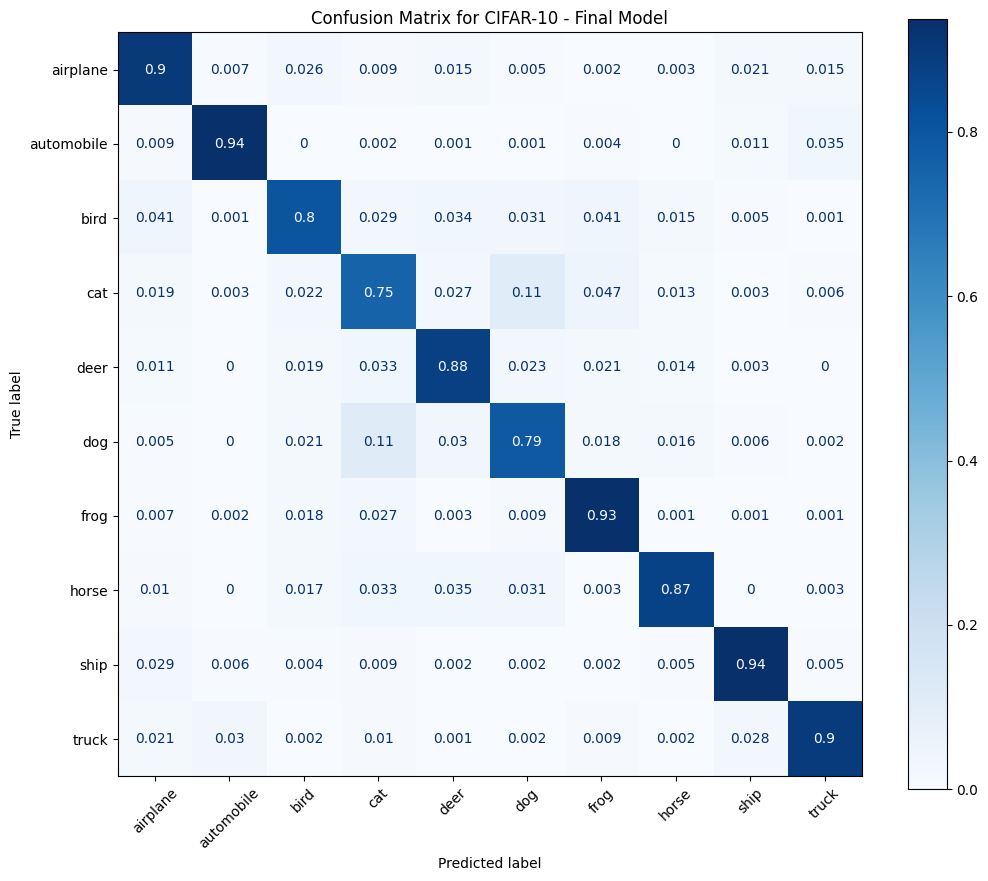

In [23]:
# ---------------------------------------------------------
# 12. Final Confusion Matrix for Best & Fully Trained Model
# ---------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [24]:
model

Cifar10CNN_v3(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [27]:
# Save both model weights and optimizer state
torch.save({
    'epoch': epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn  # optional
}, "Cifar10CNN_v3_best.pth")

print("Model saved to Cifar10CNN_v3_best.pth")

Model saved to Cifar10CNN_v3_best.pth


In [28]:
# Retrain step?

more_epochs = 30

optimizer = rs.best_params_["optimizer"](model.parameters(), lr=rs.best_params_["lr"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task='multiclass', num_classes=10).to(device)


for epoch in tqdm(range(epochs, epochs + more_epochs)):
    train_loss, train_acc = train_step(
        model, train_loader, loss_fn, optimizer, accuracy_fn, device)
    test_loss, test_acc = test_step(
        model, test_loader, loss_fn, accuracy_fn, device)
    scheduler.step()  # Update learning rate
    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} - "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}"
    )

  3%|▎         | 1/30 [00:05<02:42,  5.60s/it]

Epoch 51/50 - Train Loss: 0.4923, Train Acc: 0.83 - Test Loss: 0.5278, Test Acc: 0.82


  7%|▋         | 2/30 [00:11<02:37,  5.62s/it]

Epoch 52/50 - Train Loss: 0.4194, Train Acc: 0.85 - Test Loss: 0.5958, Test Acc: 0.81


 10%|█         | 3/30 [00:16<02:31,  5.61s/it]

Epoch 53/50 - Train Loss: 0.4153, Train Acc: 0.86 - Test Loss: 0.6163, Test Acc: 0.80


 13%|█▎        | 4/30 [00:23<02:39,  6.14s/it]

Epoch 54/50 - Train Loss: 0.4043, Train Acc: 0.86 - Test Loss: 0.5087, Test Acc: 0.83


 17%|█▋        | 5/30 [00:30<02:36,  6.25s/it]

Epoch 55/50 - Train Loss: 0.3967, Train Acc: 0.86 - Test Loss: 0.5032, Test Acc: 0.83


 20%|██        | 6/30 [00:36<02:27,  6.13s/it]

Epoch 56/50 - Train Loss: 0.3845, Train Acc: 0.87 - Test Loss: 0.6172, Test Acc: 0.80


 23%|██▎       | 7/30 [00:41<02:17,  5.98s/it]

Epoch 57/50 - Train Loss: 0.3798, Train Acc: 0.87 - Test Loss: 0.5012, Test Acc: 0.84


 27%|██▋       | 8/30 [00:47<02:12,  6.03s/it]

Epoch 58/50 - Train Loss: 0.3687, Train Acc: 0.87 - Test Loss: 0.5852, Test Acc: 0.81


 30%|███       | 9/30 [00:53<02:02,  5.86s/it]

Epoch 59/50 - Train Loss: 0.3593, Train Acc: 0.88 - Test Loss: 0.5248, Test Acc: 0.83


 33%|███▎      | 10/30 [00:58<01:55,  5.75s/it]

Epoch 60/50 - Train Loss: 0.3535, Train Acc: 0.88 - Test Loss: 0.6352, Test Acc: 0.81


 37%|███▋      | 11/30 [01:05<01:53,  5.99s/it]

Epoch 61/50 - Train Loss: 0.3447, Train Acc: 0.88 - Test Loss: 0.5704, Test Acc: 0.82


 40%|████      | 12/30 [01:12<01:55,  6.39s/it]

Epoch 62/50 - Train Loss: 0.3346, Train Acc: 0.88 - Test Loss: 0.4527, Test Acc: 0.85


 43%|████▎     | 13/30 [01:18<01:44,  6.16s/it]

Epoch 63/50 - Train Loss: 0.3312, Train Acc: 0.88 - Test Loss: 0.5269, Test Acc: 0.83


 47%|████▋     | 14/30 [01:23<01:35,  5.98s/it]

Epoch 64/50 - Train Loss: 0.3206, Train Acc: 0.89 - Test Loss: 0.4597, Test Acc: 0.85


 50%|█████     | 15/30 [01:29<01:27,  5.84s/it]

Epoch 65/50 - Train Loss: 0.3132, Train Acc: 0.89 - Test Loss: 0.7688, Test Acc: 0.78


 53%|█████▎    | 16/30 [01:35<01:20,  5.77s/it]

Epoch 66/50 - Train Loss: 0.3027, Train Acc: 0.89 - Test Loss: 0.5087, Test Acc: 0.84


 57%|█████▋    | 17/30 [01:40<01:14,  5.72s/it]

Epoch 67/50 - Train Loss: 0.2923, Train Acc: 0.90 - Test Loss: 0.4801, Test Acc: 0.85


 60%|██████    | 18/30 [01:46<01:08,  5.74s/it]

Epoch 68/50 - Train Loss: 0.2840, Train Acc: 0.90 - Test Loss: 0.5580, Test Acc: 0.83


 63%|██████▎   | 19/30 [01:52<01:04,  5.86s/it]

Epoch 69/50 - Train Loss: 0.2808, Train Acc: 0.90 - Test Loss: 0.5676, Test Acc: 0.83


 67%|██████▋   | 20/30 [01:58<00:58,  5.85s/it]

Epoch 70/50 - Train Loss: 0.2759, Train Acc: 0.90 - Test Loss: 0.4554, Test Acc: 0.86


 70%|███████   | 21/30 [02:03<00:51,  5.75s/it]

Epoch 71/50 - Train Loss: 0.2643, Train Acc: 0.91 - Test Loss: 0.4914, Test Acc: 0.85


 73%|███████▎  | 22/30 [02:10<00:48,  6.02s/it]

Epoch 72/50 - Train Loss: 0.2574, Train Acc: 0.91 - Test Loss: 0.4820, Test Acc: 0.85


 77%|███████▋  | 23/30 [02:16<00:42,  6.03s/it]

Epoch 73/50 - Train Loss: 0.2492, Train Acc: 0.91 - Test Loss: 0.4870, Test Acc: 0.85


 80%|████████  | 24/30 [02:22<00:35,  5.86s/it]

Epoch 74/50 - Train Loss: 0.2400, Train Acc: 0.92 - Test Loss: 0.4489, Test Acc: 0.86


 83%|████████▎ | 25/30 [02:27<00:28,  5.77s/it]

Epoch 75/50 - Train Loss: 0.2361, Train Acc: 0.92 - Test Loss: 0.4480, Test Acc: 0.86


 87%|████████▋ | 26/30 [02:33<00:22,  5.68s/it]

Epoch 76/50 - Train Loss: 0.2280, Train Acc: 0.92 - Test Loss: 0.4183, Test Acc: 0.87


 90%|█████████ | 27/30 [02:38<00:16,  5.64s/it]

Epoch 77/50 - Train Loss: 0.2193, Train Acc: 0.92 - Test Loss: 0.4897, Test Acc: 0.86


 93%|█████████▎| 28/30 [02:44<00:11,  5.60s/it]

Epoch 78/50 - Train Loss: 0.2137, Train Acc: 0.92 - Test Loss: 0.4268, Test Acc: 0.87


 97%|█████████▋| 29/30 [02:50<00:05,  5.82s/it]

Epoch 79/50 - Train Loss: 0.2135, Train Acc: 0.92 - Test Loss: 0.4707, Test Acc: 0.86


100%|██████████| 30/30 [02:56<00:00,  5.88s/it]

Epoch 80/50 - Train Loss: 0.2000, Train Acc: 0.93 - Test Loss: 0.4256, Test Acc: 0.87


In [29]:
train_acc, test_acc

(0.9296875, 0.8709454113924051)

In [30]:
# 11d. Final evaluation on test set with sklearn metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        X = test_transform_batch(X)   # normalize just like during training
        y_pred = model(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [31]:
# 11e. Compute metrics

print("\n✅ Final Evaluation with Sklearn Metrics")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nConfusion Matrix:\n", confusion_matrix(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


✅ Final Evaluation with Sklearn Metrics
Accuracy: 0.8695

Confusion Matrix:
 [[893   4  33   8  14   4   4   2  22  16]
 [ 11 927   3   0   1   2   8   0  19  29]
 [ 36   1 852  22  25  19  36   6   3   0]
 [ 11   0  42 717  58 101  49   9   7   6]
 [  6   0  29  16 893  26  25   5   0   0]
 [  4   0  26  86  35 812  19  12   5   1]
 [  4   0  22  17   6  10 940   0   1   0]
 [  7   1  22  27  75  30   6 827   2   3]
 [ 23   3   9   3   3   2   3   3 946   5]
 [ 26  32   5   8   2   3   8   1  27 888]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1000
           1       0.96      0.93      0.94      1000
           2       0.82      0.85      0.83      1000
           3       0.79      0.72      0.75      1000
           4       0.80      0.89      0.85      1000
           5       0.80      0.81      0.81      1000
           6       0.86      0.94      0.90      1000
           7       0.96      0.83

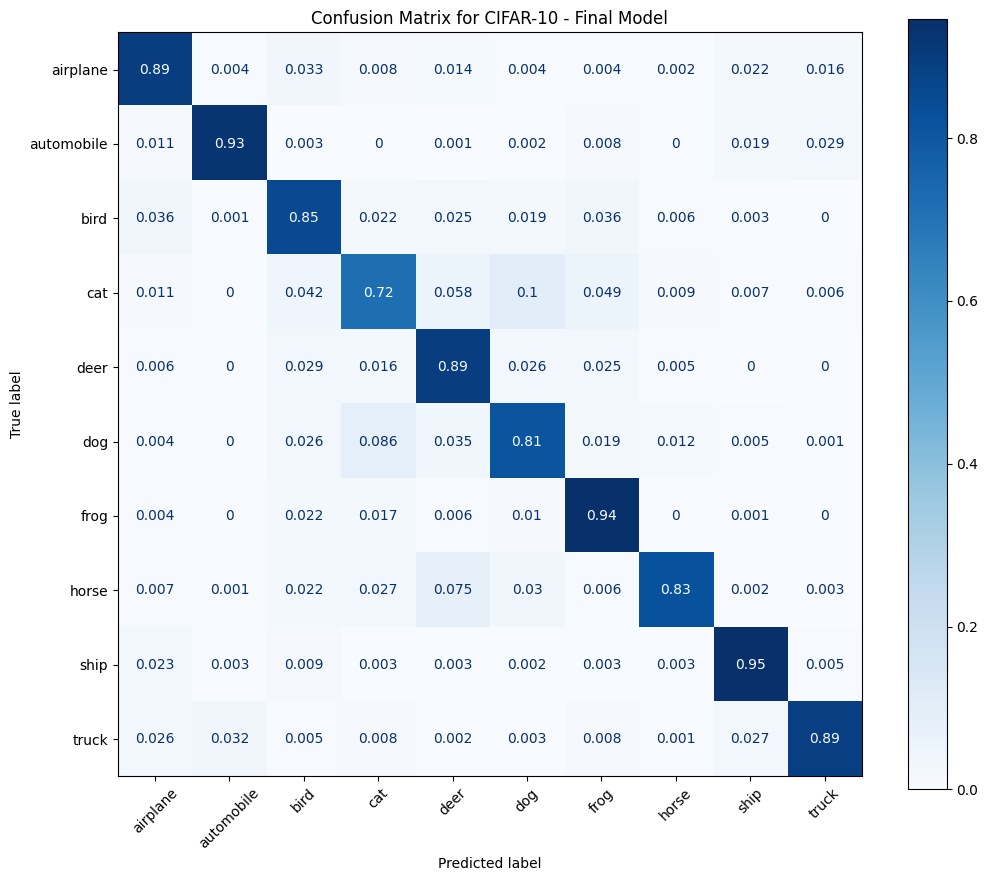

In [33]:
# 12. Final Confusion Matrix for Best & Fully Trained Model

fig, ax = plt.subplots(figsize=(12, 10))

# disp = ConfusionMatrixDisplay.from_predictions(
#     all_labels, all_preds
#     , display_labels=dataset.classes
#     , normalize='true'
# )

disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CIFAR-10 - Final Model")
plt.show();

In [34]:
# Save both model weights and optimizer state
torch.save({
    'epoch': epochs + more_epochs
    , 'model_state_dict': model.state_dict()
    , 'optimizer_state_dict': optimizer.state_dict()
    , 'loss': loss_fn,  # optional
}, "Cifar10CNN_v3_retrained_best.pth")

print("Model saved to Cifar10CNN_v3_retrained_best.pth")

Model saved to Cifar10CNN_v3_retrained_best.pth


In [35]:
torch.save(model.state_dict(), "Cifar10CNN_v3_retrained_best_weights.pth")

In [36]:
# Cifar10CNN_v3_best

torch.save(model.state_dict(), "Cifar10CNN_v3_best_weights.pth")